In [6]:
import copy, math, os, pickle, time, pandas as pd, numpy as np, scipy.stats as ss

from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score

import torch, torch.utils.data as utils, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from config import (DATA_DIR, )
from utils.eda import (load_from_pickle, save_to_pickle, append_results)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from src.models.grud_model import *

In [ ]:
%%time
X_train = load_from_pickle(f'{DATA_DIR}vitals_train.pkl')
X_dev = load_from_pickle(f'{DATA_DIR}vitals_dev.pkl')
X_test = load_from_pickle(f'{DATA_DIR}vitals_test.pkl')

Ys_train = load_from_pickle(f'{DATA_DIR}Ys_train.pkl')
Ys_dev = load_from_pickle(f'{DATA_DIR}Ys_dev.pkl')
Ys_test = load_from_pickle(f'{DATA_DIR}Ys_test.pkl')

In [ ]:
GAP_TIME          = 0  # In hours
WINDOW_SIZE       = 24 # In hours
SEED              = 42
ID_COLS           = ['subject_id', 'hadm_id', 'icustay_id']
GPU               = '2'
EARLY_STOP_FRAC = 0.1

# os.environ['CUDA_VISIBLE_DEVICES'] = GPU
torch.manual_seed(SEED)
np.random.seed(SEED)

In [82]:
from itertools import product

# Define the parameter grid
hidden_sizes = [32, 64, 128, 256]
learning_rates = [0.0001, 0.0005, 0.001]
batch_sizes = [32, 64, 128, 256, 512]

# Placeholder for storing the results
GRU_D_hyperparams_list = []

# The fixed number of epochs for training
num_epochs = 100
patience = 10

# Iterate over all combinations of hyperparameters
for batch_size, hidden_size, learning_rate in product(batch_sizes, hidden_sizes, learning_rates):

    GRU_D_hyperparams_list.append({
        'hidden_size': int(hidden_size),
        'learning_rate': learning_rate,
        'batch_size': int(batch_size),
        'patience': int(patience),
        'num_epochs': int(num_epochs)
    })
full_results = []

In [83]:
len(GRU_D_hyperparams_list)

60

In [ ]:
model_name       = 'GRU-D'
tasks             = ['mort_hosp']
hyperparams_list = GRU_D_hyperparams_list
RERUN            = False

if model_name not in full_results: full_results[model_name] = {}

t = 'mort_hosp'
if t not in full_results[model_name]: full_results[model_name][t] = {}
n, X_train, X_dev, X_test = ('full_X', X_train, X_dev, X_test)
print("Running model %s on target %s with representation %s" % (model_name, t, n))
X_mean = np.nanmean(
    to_3D_tensor(
        X_train.loc[:, pd.IndexSlice[:, 'mean']] *
        np.where((X_train.loc[:, pd.IndexSlice[:, 'mask']] == 1).values, 1, np.NaN)
    ),
    axis=0, keepdims=True
).transpose([0, 2, 1])
base_params = {'X_mean': X_mean, 'output_last': True, 'input_size': X_mean.shape[2]}

best_s, best_hyperparams = -np.Inf, None
for i, hyperparams in enumerate(hyperparams_list):
    hyperparams_print = "On sample %d / %d (hyperparams = %s)\n" % (i+1, len(hyperparams_list), repr((hyperparams)))
    print(hyperparams_print)
    append_results("training_results.txt", hyperparams_print)
    batch_size = hyperparams['batch_size']

    np.random.seed(SEED)
    all_train_subjects = list(
        np.random.permutation(Ys_train.index.get_level_values('subject_id').values)
    )
    N_early_stop        = int(len(all_train_subjects) * EARLY_STOP_FRAC)
    train_subjects      = all_train_subjects[:-N_early_stop]
    early_stop_subjects = all_train_subjects[-N_early_stop:]
    X_train_obs         = X_train[X_train.index.get_level_values('subject_id').isin(train_subjects)]
    Ys_train_obs        = Ys_train[Ys_train.index.get_level_values('subject_id').isin(train_subjects)]

    X_train_early_stop  = X_train[X_train.index.get_level_values('subject_id').isin(early_stop_subjects)]
    Ys_train_early_stop = Ys_train[
        Ys_train.index.get_level_values('subject_id').isin(early_stop_subjects)
    ]

    train_dataloader      = prepare_dataloader(X_train_obs, Ys_train_obs[t], batch_size=batch_size)
    early_stop_dataloader = prepare_dataloader(
        X_train_early_stop, Ys_train_early_stop[t], batch_size=batch_size
    )
    dev_dataloader        = prepare_dataloader(X_dev, Ys_dev[t], batch_size=batch_size)
    test_dataloader       = prepare_dataloader(X_test, Ys_test[t], batch_size=batch_size)

    model_hyperparams = copy.copy(base_params)
    model_hyperparams.update(
        {k: v for k, v in hyperparams.items() if k in ('hidden_size', 'batch_size')}   # removed cell_size
    )

    model = GRUD(**model_hyperparams)

    best_model, _ = Train_Model(
        model, train_dataloader, early_stop_dataloader,
        **{k: v for k, v in hyperparams.items() if k in (
            'num_epochs', 'patience', 'learning_rate', 'batch_size'
        )}
    )

    probabilities_dev, labels_dev = predict_proba(best_model, dev_dataloader)
    probabilities_dev = np.concatenate(probabilities_dev)[:, 1]
    labels_dev        = np.concatenate(labels_dev)
    s = roc_auc_score(labels_dev, probabilities_dev)
    if s > best_s:
        best_s, best_hyperparams = s, hyperparams
        print("New Best Score: %.2f @ hyperparams = %s" % (100*best_s, repr((best_hyperparams))))
    append_results("training_results.txt", "\n")

In [ ]:
# best hyperparameters after training
best_hyperparams = load_from_pickle('best_hyperparams.pkl')
best_hyperparams

{'hidden_size': 128,
 'learning_rate': 0.0005,
 'batch_size': 128,
 'patience': 10,
 'num_epochs': 100}

In [ ]:
# Train the final model
t = 'mort_hosp'
np.random.seed(1)
batch_size = best_hyperparams['batch_size']

X_train_concat, Ys_train_concat = pd.concat((X_train, X_dev)), pd.concat((Ys_train, Ys_dev))

X_mean_concat = np.nanmean(
    to_3D_tensor(
        X_train_concat.loc[:, pd.IndexSlice[:, 'mean']] *
        np.where((X_train_concat.loc[:, pd.IndexSlice[:, 'mask']] == 1).values, 1, np.NaN)
    ),
    axis=0, keepdims=True
).transpose([0, 2, 1])
final_base_params = {'X_mean': X_mean_concat, 'output_last': True, 'input_size': X_mean_concat.shape[2]}

train_dataloader      = prepare_dataloader(X_train_concat, Ys_train_concat[t], batch_size=batch_size)
test_dataloader       = prepare_dataloader(X_test, Ys_test[t], batch_size=batch_size)

model_hyperparams = copy.copy(final_base_params)
model_hyperparams.update(
    {k: v for k, v in best_hyperparams.items() if k in ('hidden_size', 'batch_size')}
)

In [ ]:
model = GRUD(**model_hyperparams)
trained_model = run_only_final(model, train_dataloader, best_hyperparams)
torch.save(trained_model.state_dict(), 'trained_model_org.pth')

### Step 3 - Feature Importance

---

In [9]:
t = 'mort_hosp'
np.random.seed(1)
batch_size = best_hyperparams['batch_size']

X_train_concat, Ys_train_concat = pd.concat((X_train, X_dev)), pd.concat((Ys_train, Ys_dev))

X_mean_concat = np.nanmean(
    to_3D_tensor(
        X_train_concat.loc[:, pd.IndexSlice[:, 'mean']] *
        np.where((X_train_concat.loc[:, pd.IndexSlice[:, 'mask']] == 1).values, 1, np.NaN)
    ),
    axis=0, keepdims=True
).transpose([0, 2, 1])
final_base_params = {'X_mean': X_mean_concat, 'output_last': True, 'input_size': X_mean_concat.shape[2]}

train_dataloader      = prepare_dataloader(X_train_concat, Ys_train_concat[t], batch_size=batch_size)
test_dataloader       = prepare_dataloader(X_test, Ys_test[t], batch_size=batch_size)

model_hyperparams = copy.copy(final_base_params)
model_hyperparams.update(
    {k: v for k, v in best_hyperparams.items() if k in ('hidden_size', 'batch_size')}
)

# Load the trained model's state dictionary
model = GRUD(**model_hyperparams)
model.load_state_dict(torch.load('trained_model_org.pth'))
model.eval()

GRUD(
  (zl): Linear(in_features=206, out_features=128, bias=True)
  (rl): Linear(in_features=206, out_features=128, bias=True)
  (hl): Linear(in_features=206, out_features=128, bias=True)
  (gamma_x_l): FilterLinear(in_features=39, out_features=39, bias=True)
  (gamma_h_l): Linear(in_features=39, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [10]:
def process_dataset(X, from_batch=False):
    if from_batch:
      X = X.numpy()
    mask = X[:, np.arange(0, X.shape[1], 3), :]
    measurement = X[:, np.arange(1, X.shape[1], 3), :]
    time_ = X[:, np.arange(2, X.shape[1], 3), :]

    # Transpose to match the model's expected input format
    mask = torch.transpose(torch.from_numpy(mask.astype(np.float32)), 1, 2)
    measurement = torch.transpose(torch.from_numpy(measurement.astype(np.float32)), 1, 2)
    time_ = torch.transpose(torch.from_numpy(time_.astype(np.float32)), 1, 2)

    # Prepare the last observed measurement
    measurement_last_obsv = measurement.clone()

    return measurement, measurement_last_obsv, mask, time_

In [11]:
def gradient_shap_attributions(model, train_dataloader):
    all_attributions = []

    for batch_idx, (X_batch, labels_batch) in enumerate(train_dataloader):
        # Process the actual data to match your model's input format
        background_data_processed = process_dataset(X_batch, from_batch=True)
        inputs = [background_data_processed[0], background_data_processed[1], background_data_processed[2], background_data_processed[3]]

        explainer = shap.GradientExplainer(model, inputs)
        shap_values = explainer.shap_values(inputs)

        all_attributions.append(shap_values)

    return all_attributions

In [ ]:
# # Info about all_attributions:
# len(all_attributions): 109 (number of batches)
# len(all_attributions[0]): 2 (number of class labels/predictions)
# len(all_attributions[0][0]): 4 (number of inputs in the model: measurement (the measurement imputed), measurement_last_obsv (the last actually measured value), mask (indicator if measurement is measured at this time), time_ (time since it was last measured)
# len(all_attributions[0][0][0]): 128 (batch size)
# len(all_attributions[0][0][0][0]): 48 (number of hours - first 48 hours of admission)
# len(all_attributions[0][0][0][0][0]): 39 (number of features - vital signs)

In [ ]:
# Compute attributions for each batch and aggregate
all_attributions = gradient_shap_attributions(model, train_dataloader)
save_to_pickle(all_attributions, '/content/drive/My Drive/Colab Notebooks/shap_attributions.pkl')

In [ ]:
import shap

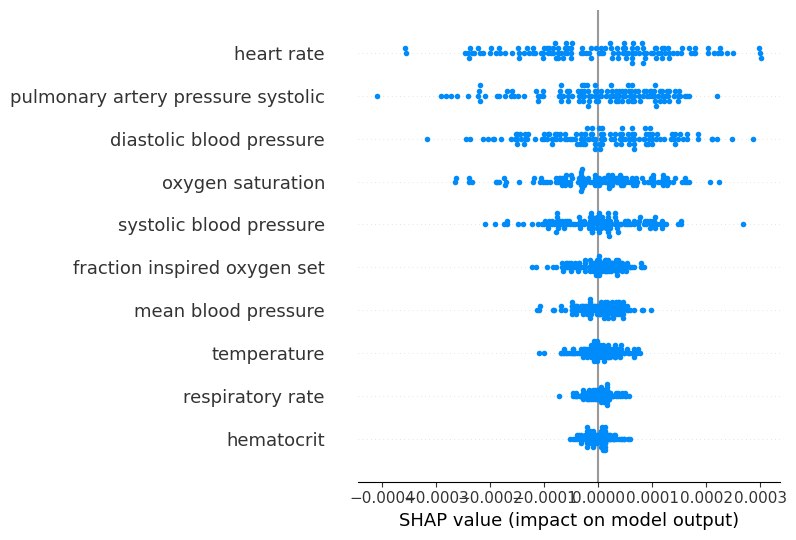

<Figure size 640x480 with 0 Axes>

In [ ]:
feature_names = X_train.columns.get_level_values(0).unique().tolist()

# all_attributions = load_from_pickle('shap_attributions.pkl')

aggregate_shap = [np.mean([batch[i][j] for batch in all_attributions], axis=0) for i in range(2) for j in range(4)]
# Example: Averaging SHAP values over time steps for the first input of class 0
average_shap_values = np.mean(aggregate_shap[0], axis=1)  # Averaging over time steps

# Visualizing feature importance
shap.summary_plot(average_shap_values, features=feature_names, plot_type='dot', alpha=0.5, plot_size=[12,8], max_display=10, show=False)
plt.savefig('shap_values.png')
top_features = ['heart rate', 'pulmonary artery pressure systolic', 'diastolic blood pressure', 'oxygen saturation', 'systolic blood pressure',
                'fraction inspired oxygen set', 'mean blood pressure', 'temperature', 'respiratory rate', 'hematocrit']
# save_to_pickle(average_shap_values, '/content/drive/My Drive/Colab Notebooks/average_shap_values.pkl')
# save_to_pickle(top_features, '/content/drive/My Drive/Colab Notebooks/shap_top_features.pkl')

In [13]:
all_attributions = load_from_pickle('shap_attributions.pkl')
average_shap_values = load_from_pickle('average_shap_values.pkl')
top_features = load_from_pickle('shap_top_features.pkl')

In [ ]:
len(all_attributions)

109

In [ ]:
import skfuzzy as fuzz

In [15]:
thresholds_df = pd.read_csv('threshold_stats.csv')
thresholds_df.drop(columns=['Unnamed: 0'], inplace=True)
train_min_df = load_from_pickle('train_min.pkl')
train_max_df = load_from_pickle('train_max.pkl')

In [ ]:
patient_shap_values = aggregate_shap_values(all_attributions)
len(patient_shap_values)

13952

###  Calculate SHAP Values for Top Features

In [ ]:
# Calculate SHAP values for the test dataset
test_shap_values = gradient_shap_attributions(model, test_dataloader)

# Aggregate SHAP values per patient
test_patient_shap_values = aggregate_shap_values(test_shap_values, batch_size=128)

In [ ]:
save_to_pickle(test_patient_shap_values, '/content/drive/My Drive/Colab Notebooks/test_patient_shap_values.pkl')

In [ ]:
X_test_agg = prepare_dataset_for_rules(X_test)
X_test_agg = X_test_agg.iloc[:len(test_dataloader)*128, :]
X_test_agg.shape

(3456, 39)

---


## Building the Data Base

In [16]:
def prepare_dataset_for_rules(df):
  X_agg = df.groupby(level='subject_id').mean()
  features = [feature for feature in X_agg.columns.get_level_values(0).unique() if 'mean' in X_agg[feature].columns]
  X_agg = X_agg.loc[:, (features, 'mean')]
  return X_agg


X_agg = prepare_dataset_for_rules(X_train_concat)
X_agg = X_agg.iloc[:len(train_dataloader)*128, :]

In [17]:
def get_fuzzy_label(value, mf_definitions):
    # Assuming mf_definitions is a dictionary of membership functions for a feature
    highest_membership = 0
    label = None
    scaled_universe = np.linspace(0, 1, 1000)
    for mf_label, mf_function in mf_definitions.items():
        membership_degree = fuzz.interp_membership(scaled_universe, mf_function, value)
        if membership_degree >= highest_membership:
            highest_membership = membership_degree
            label = mf_label  # label is a string like 'Low', 'Medium', 'High'
    return label

In [18]:
def aggregate_shap_values(all_attributions, batch_size=128):
  # Reshape and aggregate SHAP values per patient - the average SHAP value for each feature for each patient
  patient_shap_values = np.zeros((len(all_attributions) * batch_size, 39))  # Assuming 39 features

  for batch_idx, batch in enumerate(all_attributions):
      for patient_idx in range(batch_size):  # Batch size
          # Aggregate across time steps for each feature
          for feature_idx in range(39):
              patient_shap_values[batch_idx * batch_size + patient_idx, feature_idx] = np.mean(batch[0][0][patient_idx, :, feature_idx])
  return patient_shap_values

In [19]:
# Function to apply Min-Max scaling with clipping
def minmax_scaling_with_clipping(X, feature_min, feature_max):
    return np.clip((X - feature_min) / (feature_max - feature_min), 0, 1)

# Create a dictionary to hold the membership function parameters for each feature
mf_parameters = {}

for index, row in thresholds_df.iterrows():
    feature = row['measurement']
    normal_min = row['normal min']
    normal_high = row['normal high']
    valid_low = row['valid low']
    valid_high = row['valid high']
    train_min = train_min_df[feature][0]
    train_max = train_max_df[feature][0]

    # Scale the thresholds using the Min-Max scaling factors derived from the training data
    scaled_normal_min = minmax_scaling_with_clipping(normal_min, train_min, train_max)
    scaled_normal_high = minmax_scaling_with_clipping(normal_high, train_min, train_max)
    scaled_valid_low = minmax_scaling_with_clipping(valid_low, train_min, train_max)
    scaled_valid_high = minmax_scaling_with_clipping(valid_high, train_min, train_max)

    # Store the parameters for the MFs
    mf_parameters[feature] = {
        'Low': [scaled_valid_low, scaled_valid_low, scaled_normal_min],
        'Normal': [scaled_normal_min, (scaled_normal_min + scaled_normal_high) / 2, scaled_normal_high],
        'High': [scaled_normal_high, scaled_valid_high, scaled_valid_high]
    }

In [ ]:
# Now, let's define the membership functions using scikit-fuzzy
def define_membership_functions(mf_params):
    mf_definitions = {}
    universe = np.linspace(0, 1, 1000)  # Define a universe of discourse

    for feature, params in mf_params.items():
        low_params = params['Low']
        normal_params = params['Normal']
        high_params = params['High']

        # Use skfuzzy to create triangular MFs
        low_mf = fuzz.trimf(universe, low_params)
        normal_mf = fuzz.trimf(universe, normal_params)
        high_mf = fuzz.trimf(universe, high_params)

        # Store the MFs in a dictionary
        mf_definitions[feature] = {
            'Low': low_mf,
            'Normal': normal_mf,
            'High': high_mf
        }
    return mf_definitions, universe

mf_definitions, universe_of_discourse = define_membership_functions(mf_parameters)

In [37]:
len(mf_definitions['heart rate']['Normal'])

1000

In [ ]:
mf_definitions

In [ ]:
save_to_pickle(mf_parameters, 'mf_parameters.pkl')
save_to_pickle(mf_definitions, 'mf_definitions.pkl')
save_to_pickle(universe_of_discourse, 'universe_of_discourse.pkl')

In [21]:
mf_definitions = load_from_pickle('mf_definitions.pkl')
mf_parameters = load_from_pickle('mf_parameters.pkl')
universe_of_discourse = load_from_pickle('universe_of_discourse.pkl')

In [27]:
len(mf_definitions)

39

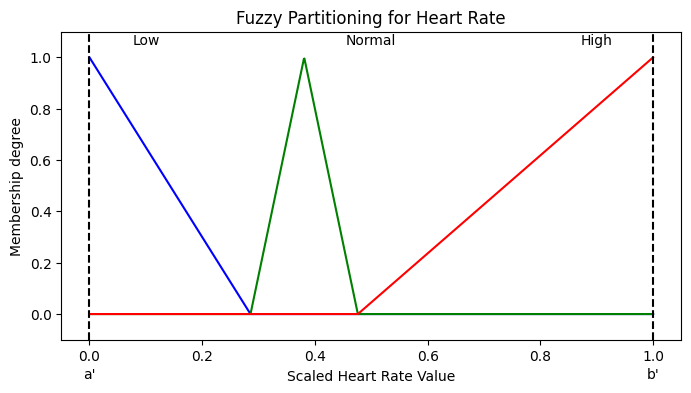

In [54]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Define the universe of discourse
universe = np.linspace(0, 1, 1000)

# The provided scaled values for 'heart rate'
low_params = mf_parameters['heart rate']['Low']
normal_params = mf_parameters['heart rate']['Normal']
high_params = mf_parameters['heart rate']['High']

# Generate the membership functions
low_mf = mf_definitions['heart rate']['Low']
normal_mf = mf_definitions['heart rate']['Normal']
high_mf = mf_definitions['heart rate']['High']

# Plot the fuzzy membership functions
plt.figure(figsize=(8, 4))

plt.plot(universe, low_mf, 'b', linewidth=1.5, label='Low')
plt.plot(universe, normal_mf, 'g', linewidth=1.5, label='Normal')
plt.plot(universe, high_mf, 'r', linewidth=1.5, label='High')

plt.title('Fuzzy Partitioning for Heart Rate')
plt.ylabel('Membership degree')
plt.xlabel('Scaled Heart Rate Value')
plt.ylim(-0.1, 1.1)

# Add the labels for 'Low', 'Medium', and 'High'
plt.text(0.1, 1.05, 'Low', ha='center', fontsize=10)
plt.text(0.5, 1.05, 'Normal', ha='center', fontsize=10)
plt.text(0.9, 1.05, 'High', ha='center', fontsize=10)

# Add the vertical lines for the universe of discourse boundaries
plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')

# Add the labels for a' and b'
plt.text(0, -0.25, "a'", ha='center')
plt.text(1, -0.25, "b'", ha='center')

# plt.legend()
plt.savefig('fuzzy-heart.png')
plt.show()

## Rule Base

### Initial Rule Generation

In [56]:
def generate_initial_rules(X_agg, patient_shap_values, scaled_mf_definitions, Ys, importance_threshold=0.0001, max_antecedents=5):
    initial_rules = []

    for patient_idx, patient_data in enumerate(X_agg.itertuples()):
        patient_shap = patient_shap_values[patient_idx]
        important_features = np.argsort(np.abs(patient_shap))[::-1]

        # Apply the threshold and limit the number of antecedents
        important_features = important_features[np.abs(patient_shap[important_features]) >= importance_threshold]
        if len(important_features) > max_antecedents:
          important_features = important_features[:max_antecedents]

        rule_antecedents = []
        for feature_idx in important_features:
            feature_name = X_agg.columns[feature_idx][0]  # format: ('vital sign', 'mean')
            feature_value = patient_data[feature_idx + 1]  # +1 due to index column in itertuples
            fuzzy_label = get_fuzzy_label(feature_value, scaled_mf_definitions[feature_name])
            if fuzzy_label:
                rule_antecedents.append((feature_name, fuzzy_label, patient_shap[feature_idx]))

        class_label = Ys.iloc[patient_idx]['mort_hosp']

        if len(rule_antecedents) > 0:
            rule = {
                'antecedents': rule_antecedents,
                'consequent': class_label
            }
            initial_rules.append(rule)

    return initial_rules

In [ ]:
initial_rules = generate_initial_rules(X_agg, patient_shap_values, mf_definitions, Ys_train_concat)
save_to_pickle(initial_rules, 'initial_rules.pkl')

### Resolving Rule Conflicts

In [59]:
def calculate_rule_weights(initial_rules):
    rule_weights = {}
    antecedent_counts = {}

    # Count occurrences of each antecedent combination
    for rule in initial_rules:
        antecedents = tuple(rule['antecedents'])
        antecedent_counts[antecedents] = antecedent_counts.get(antecedents, 0) + 1

    # Calculate the frequency level for each rule
    for rule in initial_rules:
        antecedents = tuple(rule['antecedents'])
        rule_id = id(rule)  # Unique identifier for the rule
        rule_weights[rule_id] = antecedent_counts[antecedents]

    return rule_weights

rule_weights = calculate_rule_weights(initial_rules)


### Pruning Redundant Rules

In [58]:
initial_rules = load_from_pickle('initial_rules.pkl')

In [68]:
def are_rules_similar(rule1, rule2, similarity_threshold=0.7):
    antecedents1 = set((feature_name, fuzzy_label) for feature_name, fuzzy_label, _ in rule1['antecedents'])
    antecedents2 = set((feature_name, fuzzy_label) for feature_name, fuzzy_label, _ in rule2['antecedents'])

    common_antecedents = antecedents1.intersection(antecedents2)
    similarity_score = len(common_antecedents) / max(len(antecedents1), len(antecedents2))

    return similarity_score >= similarity_threshold

def group_similar_rules(initial_rules):
    rule_groups = []
    used_rule_indices = set()

    for i, rule in enumerate(initial_rules):
        if i in used_rule_indices:
            continue

        current_group = [rule]
        used_rule_indices.add(i)

        for j, other_rule in enumerate(initial_rules):
            if j not in used_rule_indices and are_rules_similar(rule, other_rule):
                current_group.append(other_rule)
                used_rule_indices.add(j)

        rule_groups.append(current_group)

    return rule_groups

def prune_rules(rule_groups, threshold_alpha=3):
    pruned_rules = []

    for group in rule_groups:
        if len(group) >= threshold_alpha:
            # Keep the rule with the highest total absolute SHAP value
            highest_shap_rule = max(group, key=lambda rule: sum(abs(shap_value) for _, _, shap_value in rule['antecedents']))
            pruned_rules.append(highest_shap_rule)

    return pruned_rules

In [69]:
# Grouping similar rules
rule_groups = group_similar_rules(initial_rules)

In [71]:
# Pruning the rules based on the group size and highest SHAP values
pruned_rules = prune_rules(rule_groups)

In [72]:
len(pruned_rules)

447

In [77]:
pruned_rules[4]

{'antecedents': [('pulmonary artery pressure systolic',
   'High',
   -0.017258388718124),
  ('oxygen saturation', 'Low', -0.0035437484998472163),
  ('heart rate', 'Normal', -0.0010010479921093204),
  ('diastolic blood pressure', 'Low', -0.0008154085502271582),
  ('systolic blood pressure', 'Normal', 0.0006887262476584956)],
 'consequent': 0.0}

In [ ]:
# Example output
print(f"Number of pruned rules: {len(pruned_rules)}")

Number of pruned rules: 447


In [ ]:
save_to_pickle(rule_groups, 'rule_groups.pkl')
save_to_pickle(pruned_rules, 'pruned_rules.pkl')

## Prediction Time: Rule Matching & Confidence

### Rule Base Search

In [ ]:
def find_matching_rules(pruned_rules, patient_data, patient_shap_values, threshold=0.7):
    matching_rules = []
    patient_important_features = set(feature for feature, value in zip(patient_data.columns, patient_shap_values) if abs(value) >= threshold)

    for rule in pruned_rules:
        rule_important_features = set(feature for feature, _, _ in rule['antecedents'])
        if len(patient_important_features.intersection(rule_important_features)) / len(rule_important_features) >= threshold:
            matching_rules.append(rule)

    return matching_rules


### Importance Coefficient Calculation

In [ ]:
def calculate_importance_coefficient(rule, patient_shap_values, feature_names):
    coefficients = []
    for feature_name, fuzzy_label, _ in rule['antecedents']:
        if feature_name in feature_names:
            feature_index = feature_names.index(feature_name)
            patient_importance = abs(patient_shap_values[feature_index])
            rule_importance = abs(_)  # SHAP value from rule antecedent
            coefficients.append(patient_importance * rule_importance)
        else:
            coefficients.append(0)

    return sum(coefficients)

### Rule Weight Calculation

In [ ]:
def calculate_rule_weights(matching_rules, patient_shap_values, feature_names):
    rule_weights = {}
    for rule in matching_rules:
        rule_weight = calculate_importance_coefficient(rule, patient_shap_values, feature_names)
        rule_weights[id(rule)] = rule_weight

    return rule_weights

### Confidence Level Determination

In [ ]:
def calculate_confidence_level(matching_rules, rule_weights):
    total_weight = sum(rule_weights.values())
    matching_weight = sum(rule_weights[id(rule)] for rule in matching_rules)

    return matching_weight / total_weight if total_weight > 0 else 0

# Example usage
feature_names = patient_data.columns
matching_rules = find_matching_rules(pruned_rules, patient_data, patient_shap_values)
rule_weights = calculate_rule_weights(matching_rules, patient_shap_values, feature_names)
conf_level = calculate_confidence_level(matching_rules, rule_weights)

In [78]:
# Load the trained model's state dictionary
model = GRUD(**model_hyperparams)
model.load_state_dict(torch.load('trained_model_org.pth'))
model.eval()

GRUD(
  (zl): Linear(in_features=206, out_features=128, bias=True)
  (rl): Linear(in_features=206, out_features=128, bias=True)
  (hl): Linear(in_features=206, out_features=128, bias=True)
  (gamma_x_l): FilterLinear(in_features=39, out_features=39, bias=True)
  (gamma_h_l): Linear(in_features=39, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [ ]:
# Evaluate the model on the test set
def test_model(model, test_dataloader, batch_size):

    model.eval()  # Set the model on evaluation mode
    probabilities = []
    labels        = []

    use_gpu = False

    for X_test, labels_test in test_dataloader:
        X_test = X_test.numpy()
        mask_test        = torch.from_numpy(X_test[:, np.arange(0, X_test.shape[1], 3), :].astype(np.float32))
        measurement_test = torch.from_numpy(X_test[:, np.arange(1, X_test.shape[1], 3), :].astype(np.float32))
        time_test       = torch.from_numpy(X_test[:, np.arange(2, X_test.shape[1], 3), :].astype(np.float32))

        mask_test = torch.transpose(mask_test, 1, 2)
        measurement_test = torch.transpose(measurement_test, 1, 2)
        time_test = torch.transpose(time_test, 1, 2)
        measurement_last_obsv_test = measurement_test

        assert measurement_test.size()[0] == batch_size, "Batch Size doesn't match! %s" % str(measurement_test.size())

        if use_gpu:
            convert_to_cuda=lambda x: Variable(x.cuda())
            X_test, X_last_obsv_test, Mask_test, Delta_test, labels_test = map(convert_to_cuda, [measurement_test, measurement_last_obsv_test, mask_test, time_test, labels_test])
        else:
            convert_to_tensor=lambda x: Variable(x)
            X_test, X_last_obsv_test, Mask_test, Delta_test, labels_test  = map(convert_to_tensor, [measurement_test, measurement_last_obsv_test, mask_test, time_test, labels_test])

        with torch.no_grad():  # No need to track gradients for the test set
            prediction_test = model(X_test, X_last_obsv_test, Mask_test, Delta_test)

            probabilities.append(prediction_test.detach().cpu().data.numpy())
            labels.append(labels_test.detach().cpu().data.numpy())

    # Concatenate the probabilities to form a single array
    y_score = np.concatenate(probabilities)
    # Apply argmax on the probabilities along axis 1 to get the predicted classes
    y_pred = np.argmax(y_score, axis=1)

    # Concatenate the true labels to form a single array
    y_true = np.concatenate(labels)

    # Compute metrics
    auc   = roc_auc_score(y_true, y_score[:, 1])  # Use the probability of the positive class
    auprc = average_precision_score(y_true, y_score[:, 1])
    acc   = accuracy_score(y_true, y_pred)
    F1    = f1_score(y_true, y_pred)

    # Output results
    print("Final results for model %s on target %s with representation %s" % ('GRU-D', 'mort_hosp', 'full_X'))
    print(auc, auprc, acc, F1)

    return auc, auprc, acc, F1

auc, auprc, acc, F1 = test_model(model, test_dataloader, batch_size)

In [80]:
batch_size

128

### Predict Outcome for Each Patient in Test Dataset

In [ ]:
def predict_outcomes(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():
        for X_batch, _ in dataloader:
            # Process the data to match your model's input format
            X_processed = process_dataset(X_batch, from_batch=True)
            # Predict
            batch_predictions = model(X_processed[0], X_processed[1], X_processed[2], X_processed[3])
            predictions.append(batch_predictions.cpu().numpy())

    # Flatten the batched predictions
    return np.concatenate(predictions)

### Get Rules with Top 5 Features for Each Patient

In [ ]:
test_rules_per_patient = get_top_features(X_test_agg, Ys_test, test_patient_shap_values)
save_to_pickle(test_rules_per_patient, 'test_rules_per_patient.pkl')

In [ ]:
# Predicting outcomes for test dataset
test_predictions = predict_outcomes(model, test_dataloader)